# Analysis Notebook – Comparison of CV3imgt and CV3Fv simulations 

**Author:** Matteo Cagiada  

**Date:** November, 2025 

**Version:** v1.0

**Contact email:** matteo.cagiada@bio.ku.dk / matteo.cagiada@stats.ku.dk

---

## Overview

This Jupyter notebook accompanies the paper:

> **Uncovering the flexibility of CDR loops in antibodies and TCRs through large-scale molecular dynamics**  
> Matteo Cagiada, Fabian C. Spoendlin, King Ifashe, Charlotte M. Deane
> biorxiv - 2025

---

## How to Run

To run this notebook, clone the GitHub repository and run it. Then download the all-atom trajectories from the Zenodo repository (https://doi.org/10.5281/zenodo.17525665) and copy them into the '/CDR_MD_simulations/src/aa_md' folder. The trajectories need to be merged. We used MDanalysis for this, discarding the first 150 ns of the simulation for each replica and obtaining a merged trajectory of 350 ns.

The remaining CG simulations are already in the correct folders.

### Requirements
- **Python version:** 3.9+  
- **Environment:** Conda
- **Dependencies:** numpy, MDanalysis, mdtraj, pandas, matplotlib, Biopython

## functions

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import json
import random

import mdtraj as md
import MDAnalysis as mda
from MDAnalysis.analysis import align, rms
from MDAnalysis import Merge
import MDAnalysis.analysis.diffusionmap as diffusionmap
import MDAnalysis.analysis.encore as encore
from Bio.PDB import PDBParser, PPBuilder

/Users/bqm193/miniconda3/lib/python3.10/site-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [2]:
def extract_torsion_v2(u,select='all',print_res=False):
    ## for residue range use: select='resid 1:234'
    
    if select=='all':
        residues = u.residues[:]
    else:
        #residues = u.residues[select[0]:select[1]

        pdb_start = select[0]
        pdb_end = select[1]
        selection_str = f"resid {pdb_start-1}:{pdb_end+1}"
        residues = u.select_atoms(selection_str).residues
        if print_res:
            print(residues[1:-1])

    # Initialize arrays to store phi and psi angles
    phi_angles = []
    psi_angles = []
    
    # Loop over each residue to create dihedral objects for phi and psi angles
    #print(residues[0])
    for idx in range(1,len(residues)-1):
        phi_atoms = select_phi(residues[idx-1],residues[idx])
        psi_atoms = select_psi(residues[idx],residues[idx+1])
        if phi_atoms is not None and psi_atoms is not None:
            phi_angles.append(phi_atoms)
            psi_angles.append(psi_atoms)
        else:
            print('none for:',res)
            print('phi ',phi_atoms)
            print('psi ',psi_atoms)
    # Convert lists to MDAnalysis Dihedral objects
    phi_dihedrals = Dihedral(phi_angles).run()
    psi_dihedrals = Dihedral(psi_angles).run()
    # Create arrays to store angles for each frame
    phi_array = phi_dihedrals.angles
    psi_array = psi_dihedrals.angles
    # # Stack the sine and cosine results along a new last axis
    phi_sincos_array = np.stack((np.sin(np.deg2rad(phi_array)), np.cos(np.deg2rad(phi_array))), axis=-1).reshape(phi_array.shape[0],-1)
    psi_sincos_array = np.stack((np.sin(np.deg2rad(psi_array)), np.cos(np.deg2rad(psi_array))), axis=-1).reshape(psi_array.shape[0],-1) 
    # Save the torsion angles to a numpy array for each frame
    return np.stack((phi_sincos_array, psi_sincos_array), axis=-1).reshape(phi_sincos_array.shape[0],-1)

In [3]:
def calc_rmsd(u,uref,select='all',f_out=None,step=1):
    # print('First alignment')
    aligner = align.AlignTraj(u, uref, select=select, in_memory=True).run(step=step) # align to crystal structure
    Rref = rms.RMSD(u,uref,select=select) # get RMSD to reference
    Rref.run(step=step)
    coords = u.trajectory.timeseries(u.atoms,step=step) 
    coords_mean = coords.mean(axis=1) # get mean structure
    u_mean = Merge(u.atoms) # new universe from mean structure
    u_mean.load_new(coords_mean[:, None, :], order="afc")

    # print('Second alignment')
    aligner = align.AlignTraj(u, u_mean, select=select, in_memory=True).run(step=step) # align to mean structure
    coords = u.trajectory.timeseries(u.atoms,step=step) # get coords
    coords_mean = coords.mean(axis=1) # get new mean
    u_mean2 = Merge(u.atoms)
    u_mean2.load_new(coords_mean[:, None, :], order="afc")
    
    Rmean = rms.RMSD(u,u_mean2,select=select) # get RMSD to new mean structure
    Rmean.run(step=step)
    
    return Rref.results.rmsd.T,Rmean.results.rmsd.T

In [4]:
def extract_cdr_coord(dict_loc,chain,cdr_boundaries):
    with open(dict_loc,'r') as f:
        img_cv3_map=json.load(f)
    return [img_cv3_map[chain][str(elem)+'.0'] for elem in cdr_boundaries]

In [5]:

# Function to extract sequences by chain
def extract_sequences_by_chain(pdb_file):
    parser = PDBParser(QUIET=True)  # Create a parser
    structure = parser.get_structure('structure', pdb_file)  # Parse the PDB file

    sequences = {}
    ppb = PPBuilder()  # Peptide bond builder

    # Iterate through each chain in the structure
    for model in structure:
        for chain in model:
            # Build the sequence for the chain
            seq = ''
            for pp in ppb.build_peptides(chain):
                seq += pp.get_sequence()
            # Add to the dictionary, key is the chain ID
            sequences[chain.id] = seq

    return sequences

In [6]:
def dist_trajs(u_merged,select="name CA"):
    
    aligner = align.AlignTraj(u_merged, u_merged, select=select, reference_frame=0, in_memory=True)
    aligner.run()

    dist_matrix = diffusionmap.DistanceMatrix(u_merged, select=select).run()
    dmatrix=dist_matrix.results.dist_matrix
    
    return np.array(dmatrix[np.triu_indices_from(dmatrix, k=1)])


In [7]:
cdrs_list=[[27,38],[56,65],[105,117]]

In [8]:
imgt={27:28,38:39,56:57,65:66,105:106,117:118}

IMGT clusters: 1bey no cluster pdb, 1bf0 single chain

## 2Q76 - multi

#### load starting pdb and pdbs

In [9]:
folder_dict='../src/extra_pdbs/imgt2cv_dict/'

folder_pdbs=os.path.abspath('../src/extra_pdbs/pdbs_imgt/')
pdbs_all=os.listdir(folder_pdbs)

pdb_list=['2q76_Fv_DC.pdb', '2q76_Fv_BA.pdb']
chain_list=['DC','BA']

In [10]:
pdb_list

['2q76_Fv_DC.pdb', '2q76_Fv_BA.pdb']

In [11]:
chain_list

['DC', 'BA']

In [12]:
n_pdbs=len(pdb_list)

In [13]:
os.listdir('../src/metaD_clusters/D44_2Q76_clusters/')

['cluster.CL-rep.c0.pdb']

In [14]:
n_cluster=len(os.listdir('../src/metaD_clusters/D44_2Q76_clusters/'))

In [15]:
dict_prob_cluster={'cluster.CL-rep.c0.pdb':1.0}

In [16]:
cluster_pdb_list=os.listdir('../src/metaD_clusters/D44_2Q76_clusters/')
cluster_chain_list=['HL','HL','HL','HL','HL']
cluster_folder_pdbs='../src/metaD_clusters/D44_2Q76_clusters/'
cluster_pdb_prob=np.array([dict_prob_cluster[cluster] for cluster in cluster_pdb_list])

In [17]:
sys_name='2q76'
pdb_trajectories = [md.load(os.path.join('../src/metaD_clusters/D44_2Q76_clusters/',pdb_name)) for pdb_name in os.listdir('../src/metaD_clusters/D44_2Q76_clusters/')]

# Step 2: Concatenate all into a single trajectory
pdb_traj = md.join(pdb_trajectories)
pdb_traj.save_xtc(f"../src/metaD_clusters/imgt_traj_clusters/{sys_name}_joined_pdbs.xtc")

pdb_traj = mda.Universe('../src/metaD_clusters/D44_2Q76_clusters/cluster.CL-rep.c0.pdb',f"../src/metaD_clusters/imgt_traj_clusters/{sys_name}_joined_pdbs.xtc")

/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


In [18]:
rmsd_all_dist={}
rmsd_all_dist['sim_final']={'heavy':{},'light':{}}
rmsd_all_dist['sim_rigid']={'heavy':{},'light':{}}
rmsd_all_dist['sim_flexible']={'heavy':{},'light':{}}
rmsd_all_dist['sim_flexible']={'heavy':{},'light':{}}
rmsd_all_dist['fa']={'heavy':{},'light':{}}

rmsd_all_dist['metad']={'heavy':{},'light':{}}

In [19]:
chain_cluster=['H','L']
for chain_idx,chain_type in enumerate(['heavy','light']):
    for idx_cdr, cdr in enumerate(cdrs_list):
        rmsd_all_dist['metad'][chain_type][idx_cdr]=dist_trajs(pdb_traj,select=f'segid {chain_cluster[chain_idx]} and name CA and resid {cdr[0]-1}:{cdr[1]+1}')
        if len(rmsd_all_dist['metad'][chain_type][idx_cdr]) ==0:
            rmsd_all_dist['metad'][chain_type][idx_cdr]=np.array([0])

### load fa simulations

In [24]:
top_file = '../src/sims_cv3fv/2q76_DC/2q76_Fv_DC.pdb'  # Path to your PDB file
chain_sequences = extract_sequences_by_chain(top_file)

# Print sequences for each chain
for chain_id, sequence in chain_sequences.items():
    print(f"Chain {chain_id} {len(sequence)}: {sequence}")
    if chain_id == 'D':
        res_heavy=sequence
    if chain_id == 'C':
        res_light=sequence

Chain D 118: EVQLEQSGAELMKPGASVKISCKATGYTFTTYWIEWIKQRPGHSLEWIGEILPGSDSTYYNEKVKGKVTFTADASSNTAYMQLSSLTSEDSAVYYCARGDGFYVYWGQGTTLTVSSAS
Chain C 110: DIELTQSPATLSVTPGDSVSLSCRASQSISNNLHWYQQKSHESPRLLIKYTSQSMSGIPSRFSGSGSGTDFTLSINSVETEDFGVYFCQQSGSWPRTFGGGTKLDIKRAD


In [102]:
top_file = '../src/aa_md/2q76.pdb'  # Path to your PDB file
xtc_file='../src/aa_md/2q76_ion_strip.xtc'


mobile = mda.Universe(top_file,xtc_file)
ref = mda.Universe(top_file,xtc_file)


In [26]:
cv3_cdrs_light_fa=[[27,32],[50,52],[89,97]]
cv3_cdrs_heavy_fa=[[238,245],[263,270],[309,317]]

In [27]:
trajectory = md.load(xtc_file, top=top_file)  # Adjust file names/paths as needed

# Light chain
atom_indices = trajectory.topology.select('name CA and chainid 0')
# Restrict the trajectory to the selected atoms
sub_traj = trajectory.atom_slice(atom_indices)
sub_traj.center_coordinates()
rmsf_fa = md.rmsf(sub_traj, sub_traj, 0, precentered=True) *10

rmsf_fa_light=rmsf_fa[:214]
rmsf_fa_heavy=rmsf_fa[214:]

In [28]:
dict_chains={'heavy':'H', 'light':'L'}
cdr_sim=[cv3_cdrs_heavy_fa,cv3_cdrs_light_fa]

for chain_idx,chain_type in enumerate(['heavy','light']):
    for idx_cdr, cdr in enumerate(cdrs_list):
        try:
            print(idx_cdr)
            hist_counts=np.load(f'../king_ab_simulations/distances_pairwise/histogramed_data/{sys_name}_{chain_type}_{(idx_cdr+1)}_hist_fa.npy')
            rmsd_all_dist['fa'][chain_type][idx_cdr]=hist_counts
        except:
            print('na yet',cdr)
        

0
na yet [27, 38]
1
na yet [56, 65]
2
na yet [105, 117]
0
na yet [27, 38]
1
na yet [56, 65]
2
na yet [105, 117]


### load simulations

In [29]:
top_file = '../src/sims_cv3fv/2q76_DC/2q76_Fv_DC.pdb'  # Path to your PDB file
chain_sequences = extract_sequences_by_chain(top_file)

# Print sequences for each chain
for chain_id, sequence in chain_sequences.items():
    print(f"Chain {chain_id} {len(sequence)}: {sequence}")
    if chain_id == 'D':
        res_heavy_final=sequence
    if chain_id == 'C':
        res_light_final=sequence

Chain D 118: EVQLEQSGAELMKPGASVKISCKATGYTFTTYWIEWIKQRPGHSLEWIGEILPGSDSTYYNEKVKGKVTFTADASSNTAYMQLSSLTSEDSAVYYCARGDGFYVYWGQGTTLTVSSAS
Chain C 110: DIELTQSPATLSVTPGDSVSLSCRASQSISNNLHWYQQKSHESPRLLIKYTSQSMSGIPSRFSGSGSGTDFTLSINSVETEDFGVYFCQQSGSWPRTFGGGTKLDIKRAD


#### cv3fv

In [30]:
sel_chain='DC'

dict_imgt2cv='../src/sims_cv3fv/2q76_DC/2q76_dict_Fv_DC.txt'

In [31]:
prefix_sim=os.path.abspath('../src/sims_cv3fv/2q76_DC/2q76_Fv_DC')
topology_fa= os.path.join(prefix_sim+"_top.pdb")
xtc_file = os.path.join(prefix_sim+"_aligned.xtc")


mobile = mda.Universe(topology_fa,xtc_file)
ref = mda.Universe(topology_fa,xtc_file)

mobile.trajectory  # set mobile trajectory to last frame
ref.trajectory[0]  # set reference trajectory to first frame

protein = mobile.select_atoms('protein')
aligner = align.AlignTraj(mobile, ref, select='resid 1:500', in_memory=True).run()
out_traj=mobile.select_atoms("all")
out_traj.write(xtc_file, frames='all')
##dict_loc,chain,cdr_boundaries
cv3_cdrs_light_sim=[extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[0]),extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[1]),extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[2])]

cv3_cdrs_heavy_sim=[extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[0]),extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[1]),extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[2])]

In [32]:
_,Rmean_cdr1_light_final=calc_rmsd(mobile,ref,select=f'backbone and resid {cv3_cdrs_light_sim[0][0]}:{cv3_cdrs_light_sim[0][1]}')
_,Rmean_cdr2_light_final=calc_rmsd(mobile,ref,select=f'backbone and resid {cv3_cdrs_light_sim[1][0]}:{cv3_cdrs_light_sim[1][1]}')
_,Rmean_cdr3_light_final=calc_rmsd(mobile,ref,select=f'backbone and resid {cv3_cdrs_light_sim[2][0]}:{cv3_cdrs_light_sim[2][1]}')

_,Rmean_cdr1_heavy_final=calc_rmsd(mobile,ref,select=f'backbone and resid {cv3_cdrs_heavy_sim[0][0]}:{cv3_cdrs_heavy_sim[0][1]}')
_,Rmean_cdr2_heavy_final=calc_rmsd(mobile,ref,select=f'backbone and resid {cv3_cdrs_heavy_sim[1][0]}:{cv3_cdrs_heavy_sim[1][1]}')
_,Rmean_cdr3_heavy_final=calc_rmsd(mobile,ref,select=f'backbone and resid {cv3_cdrs_heavy_sim[2][0]}:{cv3_cdrs_heavy_sim[2][1]}')


/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/memory.py:535: DeprecationWarning: asel argument to timeseries will be renamed to'atomgroup' in 3.0, see #3911
  warnings.warn(


In [33]:
trajectory = md.load(xtc_file, top=topology_fa)  # Adjust file names/paths as needed

# Light chain
atom_indices = trajectory.topology.select('name CA and chainid 0')
# Restrict the trajectory to the selected atoms
sub_traj = trajectory.atom_slice(atom_indices)
sub_traj.center_coordinates()
rmsf_sim = md.rmsf(sub_traj, sub_traj, 0, precentered=True) *10

rmsf_final_heavy=rmsf_sim[:len(res_heavy_final)]
rmsf_final_light=rmsf_sim[-(len(res_light_final)):]

In [34]:
chain_sim=['P000','P001']
cdr_sim=[cv3_cdrs_heavy_sim,cv3_cdrs_light_sim]
for chain_idx,chain_type in enumerate(['heavy','light']):
    for idx_cdr, cdr in enumerate(cdrs_list):
        try:
            dist_array=dist_trajs(mobile,select=f'segid {chain_sim[chain_idx]} and name CA and resid {cdr_sim[chain_idx][idx_cdr][0]-1}:{cdr_sim[chain_idx][idx_cdr][1]+1}').flatten()
            hist_counts, bin_edges = np.histogram(dist_array, bins=40, range=(0, 5.0), density=True)
            np.save(f'../histogramed_data/{sys_name}_{chain_type}_{(idx_cdr+1)}_hist_cv3.npy',hist_counts)
        except:
            print('dist array not found',cdr)
        

dist array not found [27, 38]
dist array not found [56, 65]
dist array not found [105, 117]
dist array not found [27, 38]
dist array not found [56, 65]
dist array not found [105, 117]


In [35]:
chain_sim=['P000','P001']
cdr_sim=[cv3_cdrs_heavy_sim,cv3_cdrs_light_sim]
for chain_idx,chain_type in enumerate(['heavy','light']):
    for idx_cdr, cdr in enumerate(cdrs_list):
        hist_counts=np.load(f'../src/aa_md/histogramed_data/{sys_name}_{chain_type}_{(idx_cdr+1)}_hist_cv3.npy')
        rmsd_all_dist['sim_final'][chain_type][idx_cdr]=hist_counts


In [36]:
cv3_cdrs_light_sim_final=cv3_cdrs_light_sim
cv3_cdrs_heavy_sim_final=cv3_cdrs_heavy_sim


#### cv3imgt

In [37]:
topology_fa= '../src/sims_cv3imgt/2q76_Fv_DC_999/2q76_Fv_DC.pdb'
xtc_file = '../src/sims_cv3imgt/2q76_Fv_DC_999/2q76_Fv_DC_aligned.xtc'

mobile = mda.Universe(topology_fa,xtc_file)
ref = mda.Universe(topology_fa,xtc_file)

mobile.trajectory  # set mobile trajectory to last frame
ref.trajectory[0]  # set reference trajectory to first frame
cv3_cdrs_light_sim=[[143,148],[166,168],[205,213]]
cv3_cdrs_heavy_sim=[[26,33],[51,58],[97,105]]

In [38]:
_,Rmean_cdr1_light_flexible=calc_rmsd(mobile,ref,select=f'backbone and resid {cv3_cdrs_light_sim[0][0]}:{cv3_cdrs_light_sim[0][1]}')
_,Rmean_cdr2_light_flexible=calc_rmsd(mobile,ref,select=f'backbone and resid {cv3_cdrs_light_sim[1][0]}:{cv3_cdrs_light_sim[1][1]}')
_,Rmean_cdr3_light_flexible=calc_rmsd(mobile,ref,select=f'backbone and resid {cv3_cdrs_light_sim[2][0]}:{cv3_cdrs_light_sim[2][1]}')

_,Rmean_cdr1_heavy_flexible=calc_rmsd(mobile,ref,select=f'backbone and resid {cv3_cdrs_heavy_sim[0][0]}:{cv3_cdrs_heavy_sim[0][1]}')
_,Rmean_cdr2_heavy_flexible=calc_rmsd(mobile,ref,select=f'backbone and resid {cv3_cdrs_heavy_sim[1][0]}:{cv3_cdrs_heavy_sim[1][1]}')
_,Rmean_cdr3_heavy_flexible=calc_rmsd(mobile,ref,select=f'backbone and resid {cv3_cdrs_heavy_sim[2][0]}:{cv3_cdrs_heavy_sim[2][1]}')


In [39]:
trajectory = md.load(xtc_file, top=topology_fa)  # Adjust file names/paths as needed

# Light chain
atom_indices = trajectory.topology.select('name CA and chainid 0')
# Restrict the trajectory to the selected atoms
sub_traj = trajectory.atom_slice(atom_indices)
sub_traj.center_coordinates()
rmsf_sim = md.rmsf(sub_traj, sub_traj, 0, precentered=True) *10

rmsf_flexible_heavy=rmsf_sim[:len(res_heavy_final)]
rmsf_flexible_light=rmsf_sim[-(len(res_light_final)):]

In [40]:
chain_sim=['P000','P001']
cdr_sim=[cv3_cdrs_heavy_sim,cv3_cdrs_light_sim]
for chain_idx,chain_type in enumerate(['heavy','light']):
    for idx_cdr, cdr in enumerate(cdrs_list):
        try:
            print(idx_cdr)
            dist_array=dist_trajs(mobile,select=f'segid {chain_sim[chain_idx]} and name CA and resid {cdr_sim[chain_idx][idx_cdr][0]-1}:{cdr_sim[chain_idx][idx_cdr][1]+1}').flatten()
            hist_counts, bin_edges = np.histogram(dist_array, bins=40, range=(0, 5.0), density=True)
            np.save(f'../src/aa_md/histogramed_data/{sys_name}_{chain_type}_{(idx_cdr+1)}_hist_cv3_flexible.npy',hist_counts)
        except:
            print('dist array not found',cdr)
        

0
1
2
0
1
2


In [41]:
chain_sim=['P000','P001']
cdr_sim=[cv3_cdrs_heavy_sim,cv3_cdrs_light_sim]
for chain_idx,chain_type in enumerate(['heavy','light']):
    for idx_cdr, cdr in enumerate(cdrs_list):
        hist_counts=np.load(f'../src/aa_md/histogramed_data/{sys_name}_{chain_type}_{(idx_cdr+1)}_hist_cv3_flexible.npy')
        rmsd_all_dist['sim_flexible'][chain_type][idx_cdr]=hist_counts


### encore

In [42]:
hes_matrix_2q76={'CDRL1':{},'CDRL2':{},'CDRL3':{},'CDRH1':{},'CDRH2':{},'CDRH3':{}}

In [43]:
top_aa_file = '/Users/bqm193/lavoro/PD_Oxford/OPIG/prj_loop_ensemble_pred/final_data/king_ab_simulations/2q76.pdb'  # Path to your PDB file
xtc_aa_file='/Users/bqm193/lavoro/PD_Oxford/OPIG/prj_loop_ensemble_pred/final_data/king_ab_simulations/2q76_ion_strip_aligned_sub.xtc'

prefix_sim=os.path.abspath('../src/sims_cv3fv/2q76_DC/2q76_Fv_DC')
topology_cg= os.path.join(prefix_sim+"_top.pdb")
xtc_file = os.path.join(prefix_sim+"_aligned.xtc")

topology_cv3= '../src/sims_cv3imgt/2q76_Fv_DC_999/2q76_Fv_DC.pdb'

xtc_cv3 = '../src/sims_cv3imgt/2q76_Fv_DC_999/2q76_Fv_DC_aligned.xtc'

In [44]:
cv3_cdrs_heavy_sim=[[26, 33], [51, 58], [97, 105]]
cv3_cdrs_light_sim=[[145, 150], [168, 170], [207, 215]]
cv3_cdrs_light_fa=[[27,32],[50,52],[89,97]]
cv3_cdrs_heavy_fa=[[238,245],[263,270],[309,317]]
cv3_vanilla_cdrs_light_sim=[[143,148],[166,168],[205,213]]
cv3_vanilla_cdrs_heavy_sim=[[26,33],[51,58],[97,105]]

In [45]:
sys_print='2q76'
n=20

for idx,cdr_sel in enumerate([1,2,3]):
    
    ens_aa = mda.Universe(top_aa_file, xtc_aa_file)
    ens_CG = mda.Universe(topology_cg,xtc_file)
    ens_CV = mda.Universe(topology_cv3,xtc_cv3)

    sel_str_aa = f"resid {cv3_cdrs_heavy_fa[idx][0]}:{cv3_cdrs_heavy_fa[idx][1]}"
    sel_str_cg = f"resid {cv3_cdrs_heavy_sim[idx][0]}:{cv3_cdrs_heavy_sim[idx][1]}"
    sel_str_cv = f"resid {cv3_vanilla_cdrs_heavy_sim[idx][0]}:{cv3_vanilla_cdrs_heavy_sim[idx][1]}"
    
    # Apply selection to each universe
    sel_aa =ens_aa.select_atoms(sel_str_aa)
    
    with mda.Writer(f"../src/encore_ensemble/{sys_print}_CDRH{cdr_sel}_aa_selection.dcd", sel_aa.n_atoms) as W:
        for i, ts in enumerate(ens_aa.trajectory):       
            if i % n == 0:
                W.write(sel_aa)
    
    # Save also the topology for the selection
    sel_aa.write(f"../src/encore_ensemble/{sys_print}_CDRH{cdr_sel}_aa_selection.pdb")
    
    sel_cg =ens_CG.select_atoms(sel_str_cg)
    with mda.Writer(f"../src/encore_ensemble/{sys_print}_CDRH{cdr_sel}_cg_selection.dcd", sel_cg.n_atoms) as W:
        for ts in ens_CG.trajectory:
            W.write(sel_cg)
    
    # Save also the topology for the selection
    sel_cg.write(f"../src/encore_ensemble/{sys_print}_CDRH{cdr_sel}_cg_selection.pdb")
    
    sel_cv =ens_CV.select_atoms(sel_str_cv)
    with mda.Writer(f"../src/encore_ensemble/{sys_print}_CDRH{cdr_sel}_cv_selection.dcd", sel_cv.n_atoms) as W:
        for ts in ens_CV.trajectory:
            W.write(sel_cv)
    
    # Save also the topology for the selection
    sel_cv.write(f"../src/encore_ensemble/{sys_print}_CDRH{cdr_sel}_cv_selection.pdb")

/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "
/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


In [46]:
sys_print='2q76'
n=20

for idx,cdr_sel in enumerate([1,2,3]):
    
    ens_aa = mda.Universe(top_aa_file, xtc_aa_file)
    ens_CG = mda.Universe(topology_cg,xtc_file)

    sel_str_aa = f"resid {cv3_cdrs_heavy_fa[idx][0]}:{cv3_cdrs_heavy_fa[idx][1]}"
    sel_str_cg = f"resid {cv3_cdrs_heavy_sim[idx][0]}:{cv3_cdrs_heavy_sim[idx][1]}"
    
    # Apply selection to each universe
    sel_aa =ens_aa.select_atoms(sel_str_aa)
    
    with mda.Writer(f"../src/encore_ensemble/{sys_print}_CDRH{cdr_sel}_aa_selection.dcd", sel_aa.n_atoms) as W:
        for i, ts in enumerate(ens_aa.trajectory):       
            if i % n == 0:
                W.write(sel_aa)
    
    # Save also the topology for the selection
    sel_aa.write(f"../src/encore_ensemble/{sys_print}_CDRH{cdr_sel}_aa_selection.pdb")
    
    sel_cg =ens_CG.select_atoms(sel_str_cg)
    with mda.Writer(f"../src/encore_ensemble/{sys_print}_CDRH{cdr_sel}_cg_selection.dcd", sel_cg.n_atoms) as W:
        for ts in ens_CG.trajectory:
            W.write(sel_cg)
    
    # Save also the topology for the selection
    sel_cg.write(f"../src/encore_ensemble/{sys_print}_CDRH{cdr_sel}_cg_selection.pdb")


In [47]:
sys_print='2q76'

for idx,cdr_sel in enumerate([1,2,3]):
    u_aa = mda.Universe(f"../src/encore_ensemble/{sys_print}_CDRH{cdr_sel}_aa_selection.pdb", f"../src/encore_ensemble/{sys_print}_CDRH{cdr_sel}_aa_selection.dcd")
    u_cg = mda.Universe(f"../src/encore_ensemble/{sys_print}_CDRH{cdr_sel}_cg_selection.pdb",f"../src/encore_ensemble/{sys_print}_CDRH{cdr_sel}_cg_selection.dcd")
    u_cv = mda.Universe(f"../src/encore_ensemble/{sys_print}_CDRH{cdr_sel}_cv_selection.pdb",f"../src/encore_ensemble/{sys_print}_CDRH{cdr_sel}_cv_selection.dcd")
    
    print(u_cg.residues)
    hes_matrix= encore.hes([u_aa, u_cg, u_cv], select='name CA', align=True)[0]

    ## add manually pdb and start as they don't make convergence
    
    # convert to integers (rounded) and print nicely
    hes_matrix_2q76[f'CDRH{cdr_sel}']= np.rint(hes_matrix).astype(int)
    print(hes_matrix_2q76[f'CDRH{cdr_sel}'])

/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


<ResidueGroup [<Residue GLY, 26>, <Residue TYR, 27>, <Residue THR, 28>, <Residue PHE, 29>, <Residue THR, 30>, <Residue THR, 31>, <Residue TYR, 32>, <Residue TRP, 33>]>
[[  0  22 989]
 [ 22   0 382]
 [989 382   0]]
<ResidueGroup [<Residue ILE, 51>, <Residue LEU, 52>, <Residue PRO, 53>, <Residue GLY, 54>, <Residue SER, 55>, <Residue ASP, 56>, <Residue SER, 57>, <Residue THR, 58>]>
[[  0  47 730]
 [ 47   0 199]
 [730 199   0]]
<ResidueGroup [<Residue ALA, 97>, <Residue ARG, 98>, <Residue GLY, 99>, <Residue ASP, 100>, <Residue GLY, 101>, <Residue PHE, 102>, <Residue TYR, 103>, <Residue VAL, 104>, <Residue TYR, 105>]>
[[  0 110 560]
 [110   0 438]
 [560 438   0]]


In [48]:
sys_print='2q76'
n=20

for idx,cdr_sel in enumerate([1,2,3]):
    
    ens_aa = mda.Universe(top_aa_file, xtc_aa_file)
    ens_CG = mda.Universe(topology_cg,xtc_file)
    ens_CV = mda.Universe(topology_cv3,xtc_cv3)


    sel_str_aa = f"resid {cv3_cdrs_light_fa[idx][0]}:{cv3_cdrs_light_fa[idx][1]}"
    sel_str_cg = f"resid {cv3_cdrs_light_sim[idx][0]}:{cv3_cdrs_light_sim[idx][1]}"
    sel_str_cv = f"resid {cv3_vanilla_cdrs_light_sim[idx][0]}:{cv3_vanilla_cdrs_light_sim[idx][1]}"

    # Apply selection to each universe
    sel_aa =ens_aa.select_atoms(sel_str_aa)
    
    with mda.Writer(f"../src/encore_ensemble/{sys_print}_CDRL{cdr_sel}_aa_selection.dcd", sel_aa.n_atoms) as W:
        for i, ts in enumerate(ens_aa.trajectory):       
            if i % n == 0:
                W.write(sel_aa)
    
    # Save also the topology for the selection
    sel_aa.write(f"../src/encore_ensemble/{sys_print}_CDRL{cdr_sel}_aa_selection.pdb")
    
    sel_cg =ens_CG.select_atoms(sel_str_cg)
    with mda.Writer(f"../src/encore_ensemble/{sys_print}_CDRL{cdr_sel}_cg_selection.dcd", sel_cg.n_atoms) as W:
        for ts in ens_CG.trajectory:
            W.write(sel_cg)
    
    # Save also the topology for the selection
    sel_cg.write(f"../src/encore_ensemble/{sys_print}_CDRL{cdr_sel}_cg_selection.pdb")
    
    sel_cv =ens_CV.select_atoms(sel_str_cv)
    with mda.Writer(f"../src/encore_ensemble/{sys_print}_CDRL{cdr_sel}_cv_selection.dcd", sel_cv.n_atoms) as W:
        for ts in ens_CV.trajectory:
            W.write(sel_cv)
    
    # Save also the topology for the selection
    sel_cv.write(f"../src/encore_ensemble/{sys_print}_CDRL{cdr_sel}_cv_selection.pdb")

In [49]:
sys_print='2q76'

for idx,cdr_sel in enumerate([1,2,3]):
    u_aa = mda.Universe(f"../src/encore_ensemble/{sys_print}_CDRL{cdr_sel}_aa_selection.pdb", f"../src/encore_ensemble/{sys_print}_CDRL{cdr_sel}_aa_selection.dcd")
    u_cg = mda.Universe(f"../src/encore_ensemble/{sys_print}_CDRL{cdr_sel}_cg_selection.pdb",f"../src/encore_ensemble/{sys_print}_CDRL{cdr_sel}_cg_selection.dcd")
    u_cv = mda.Universe(f"../src/encore_ensemble/{sys_print}_CDRL{cdr_sel}_cv_selection.pdb",f"../src/encore_ensemble/{sys_print}_CDRL{cdr_sel}_cv_selection.dcd")
    print(u_aa.residues)
    print(u_cg.residues)
    print(u_cv.residues)
    hes_matrix = encore.hes([u_aa, u_cg, u_cv], select='name CA', align=True)[0]
    # convert to integers (rounded) and print nicely
    hes_matrix_2q76[f'CDRL{cdr_sel}'] = np.rint(hes_matrix).astype(int)
    print(hes_matrix_2q76[f'CDRL{cdr_sel}'])

<ResidueGroup [<Residue GLN, 27>, <Residue SER, 28>, <Residue ILE, 29>, <Residue SER, 30>, <Residue ASN, 31>, <Residue ASN, 32>]>
<ResidueGroup [<Residue GLN, 145>, <Residue SER, 146>, <Residue ILE, 147>, <Residue SER, 148>, <Residue ASN, 149>, <Residue ASN, 150>]>
<ResidueGroup [<Residue GLN, 143>, <Residue SER, 144>, <Residue ILE, 145>, <Residue SER, 146>, <Residue ASN, 147>, <Residue ASN, 148>]>
[[  0  86 506]
 [ 86   0  69]
 [506  69   0]]
<ResidueGroup [<Residue TYR, 50>, <Residue THR, 51>, <Residue SER, 52>]>
<ResidueGroup [<Residue TYR, 168>, <Residue THR, 169>, <Residue SER, 170>]>
<ResidueGroup [<Residue TYR, 166>, <Residue THR, 167>, <Residue SER, 168>]>
[[0 1 2]
 [1 0 2]
 [2 2 0]]
<ResidueGroup [<Residue GLN, 89>, <Residue GLN, 90>, <Residue SER, 91>, <Residue GLY, 92>, <Residue SER, 93>, <Residue TRP, 94>, <Residue PRO, 95>, <Residue ARG, 96>, <Residue THR, 97>]>
<ResidueGroup [<Residue GLN, 207>, <Residue GLN, 208>, <Residue SER, 209>, <Residue GLY, 210>, <Residue SER, 211

### plots

In [50]:
system_name='2Q76'

In [51]:
size_clusters=np.array([250*np.sqrt(dict_prob_cluster[cluster_file]) for cluster_file in reversed(os.listdir('../src/metaD_clusters/D44_2Q76_clusters/'))])

In [52]:
start_chain_light_final=len(res_heavy_final)
start_chain_light=len(res_heavy)

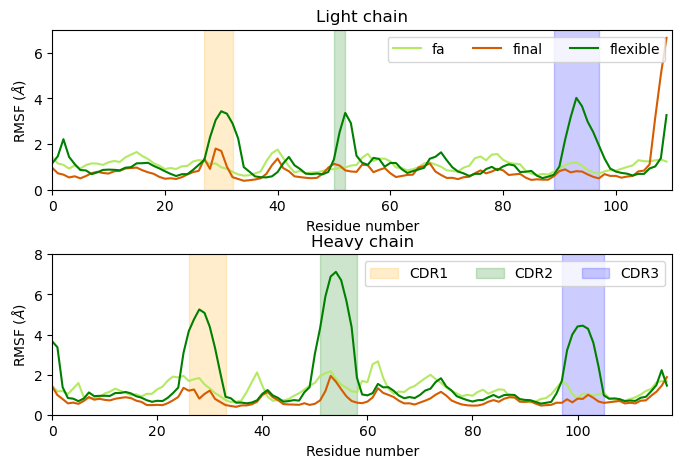

In [53]:
fig,(axs)=plt.subplots(2,1,figsize=(8,5),gridspec_kw={'hspace': 0.4})

axs[0].plot([i for i in range(len(res_light))],rmsf_fa_light[:110],color='#b4e964',label='fa')
axs[0].plot([i for i in range(len(res_light_final))],rmsf_final_light, label='final',color='#d55c00')
axs[0].plot([i for i in range(len(res_light_final))],rmsf_flexible_light, label='flexible',color='green')

axs[0].set_xlabel('Residue number')
axs[0].set_ylabel('RMSF ($\AA$)')
axs[0].axvspan(cv3_cdrs_light_sim[0][0]-start_chain_light,cv3_cdrs_light_sim[0][1]-start_chain_light, zorder=0, alpha=0.2, color='orange')
axs[0].axvspan(cv3_cdrs_light_sim[1][0]-start_chain_light,cv3_cdrs_light_sim[1][1]-start_chain_light, zorder=0, alpha=0.2, color='green')
axs[0].axvspan(cv3_cdrs_light_sim[2][0]-start_chain_light,cv3_cdrs_light_sim[2][1]-start_chain_light, zorder=0, alpha=0.2, color='blue')
axs[0].set_ylim(0,7)
axs[0].set_title('Light chain')
axs[0].set_xlim(0,len(res_light))
axs[0].legend(ncol=3)


axs[1].plot([i for i in range(len(res_heavy))],rmsf_fa_heavy[:len(res_heavy)],color='#b4e964')
axs[1].plot([i for i in range(len(res_heavy_final))],rmsf_final_heavy,color='#d55c00')
axs[1].plot([i for i in range(len(res_heavy_final))],rmsf_flexible_heavy,color='green')

axs[1].set_xlabel('Residue number')
axs[1].set_ylabel('RMSF ($\AA$)')
axs[1].axvspan(cv3_cdrs_heavy_sim[0][0],cv3_cdrs_heavy_sim[0][1], zorder=0, alpha=0.2, color='orange', label='CDR1')
axs[1].axvspan(cv3_cdrs_heavy_sim[1][0],cv3_cdrs_heavy_sim[1][1], zorder=0, alpha=0.2, color='green', label='CDR2')
axs[1].axvspan(cv3_cdrs_heavy_sim[2][0],cv3_cdrs_heavy_sim[2][1], zorder=0, alpha=0.2, color='blue', label='CDR3')
axs[1].set_ylim(0,8)
axs[1].legend(ncol=3)
axs[1].set_title('Heavy chain')

axs[1].set_xlim(0,len(res_heavy))
plt.savefig(f'../figures/{system_name}_restraints_rmsf_different_cv3_setups.pdf')
#print('RMSE light all chain:',rmse_light_all)
#print('RMSE heavy all chain:',rmse_heavy_all)

['fa', 'sim_final', 'sim_flexible', 'metad']


/var/folders/8w/2dqxrgsd4vj00wv819dcz51w0000gn/T/ipykernel_59434/327330915.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


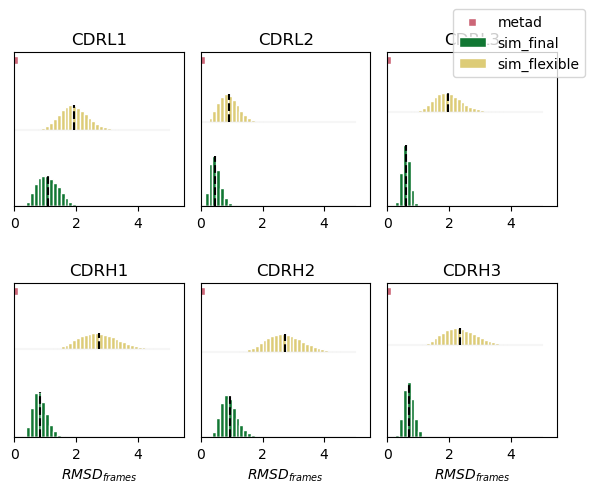

In [54]:
fig, axes = plt.subplots(2, 3, figsize=(7, 5),
                         gridspec_kw={'hspace': 0.5, 'wspace': 0.1})
colors = ['#88CCEE','#117733','#DDCC77','#CC6677','#AB6D52']  # One color per method
methods = ['fa','sim_final', 'sim_flexible','metad'] 
print(methods)
# Ensure axes is 2D
axes = np.atleast_2d(axes)
for row_idx,chain_id in enumerate(['light','heavy']):
    for col_idx, cdr in enumerate([1, 2, 3]):
        ax = axes[row_idx, col_idx]
        bottom_meth=0
        for method_idx, method in enumerate(methods):
            try:
                data = rmsd_all_dist[method][chain_id][(cdr)-1]
                if method == 'metad':
                    y = [bottom_meth] * len(data)
                    ax.scatter(data, y, facecolor=colors[method_idx], edgecolor='white',marker='s', 
                               s=30., label=method if row_idx == 0 else "")
                    
                else:
                    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

                    data_sum = data.sum()
                    data_normalized = data / data_sum
                    
                    ax.bar(bin_centers, data_normalized, width=(bin_edges[1] - bin_edges[0]),color=colors[method_idx], edgecolor='w',
                           label=method if row_idx == 0 else "",bottom=bottom_meth)
                    mean = np.sum(bin_centers * data_normalized)
                    
                    ax.plot([0,5],[bottom_meth,bottom_meth],color='lightgray',alpha=0.2)
                    ax.plot([mean,mean],[bottom_meth,bottom_meth+np.max(data_normalized)],ls='--',color='k')
                    bottom_meth=bottom_meth+np.max(data_normalized)+0.2
                    
            except KeyError:
                pass
    
        ax.set_xlim(0, 5.5)
        ax.set_yticks([])
        if row_idx == len(pdb_list) - 1:
            ax.set_xlabel(r'$ RMSD_{frames}$')
        if row_idx == 0:
            ax.set_title(f"CDRL{cdr}")
        if row_idx == 1:
            ax.set_title(f"CDRH{cdr}")
# Add a legend only once
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.95, 0.98))
plt.tight_layout()

plt.savefig(f'../figures/{system_name}_sims_metad_rmsd_pairwise_cv3_setups.pdf')

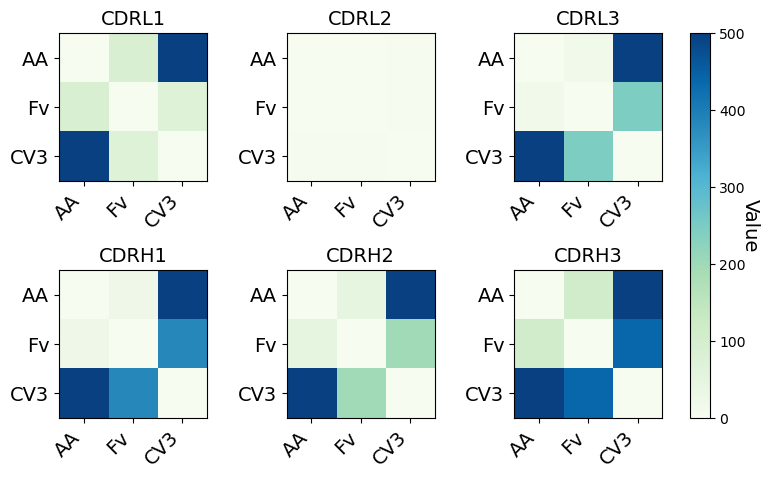

In [55]:
fig, axs = plt.subplots(2, 3, figsize=(9, 5), gridspec_kw={'hspace': 0.6, 'wspace': 0.25})
labels = ['AA', 'Fv', 'CV3']  # your custom tick labels

axs = axs.flatten()

# Keep a reference to one image to attach the shared colorbar
im = None

for idx, cdr in enumerate(hes_matrix_2q76.keys()):
    im = axs[idx].imshow(hes_matrix_2q76[cdr], cmap='GnBu', vmin=0, vmax=500)

    axs[idx].set_title(cdr, fontsize=14)

    # Set tick positions and labels
    axs[idx].set_xticks(range(len(labels)))
    axs[idx].set_xticklabels(labels, rotation=45, ha='right', fontsize=14)

    axs[idx].set_yticks(range(len(labels)))
    axs[idx].set_yticklabels(labels, fontsize=14)

# One shared colorbar on the right
cbar = fig.colorbar(im, ax=axs, location='right', fraction=0.046, pad=0.04)
cbar.ax.set_ylabel('Value', rotation=270, labelpad=10, fontsize=14)

plt.savefig('../figures/hes_matrices_2q76.pdf')

## 3V6F - multi

#### load starting pdb and pdbs

#### load starting pdb

In [56]:
dict_cv2imgt='../src/sims_cv3fv/3v6f_HL/3v6f_dict_Fv_HL.txt'

pdb_start=os.path.abspath('../src/sims_cv3fv/3v6f_HL/3v6f_Fv_HL.pdb')

chain_list='HL'

In [57]:
chain_list

'HL'

In [58]:
os.listdir('../src/metaD_clusters/3V6F_clusters/')

['cluster_8.pdb',
 'cluster_4.pdb',
 'cluster_5.pdb',
 'cluster_7.pdb',
 'cluster_6.pdb',
 'cluster_2.pdb',
 'cluster_3.pdb',
 'cluster_1.pdb',
 'cluster_0.pdb']

In [59]:
n_cluster=len(os.listdir('../src/metaD_clusters/3V6F_clusters/'))

In [60]:
dict_prob_cluster={'cluster_0.pdb':0.9,'cluster_1.pdb':0.8,'cluster_2.pdb':0.7,'cluster_3.pdb':0.6,'cluster_4.pdb':0.5,'cluster_5.pdb':0.4,
                  'cluster_6.pdb':0.3,'cluster_7.pdb':0.2,'cluster_8.pdb':0.1}

In [61]:
cluster_pdb_list=os.listdir('../src/metaD_clusters/3V6F_clusters/')
cluster_chain_list=['HL','HL','HL','HL','HL']
cluster_folder_pdbs='../src/metaD_clusters/3V6F_clusters/'
cluster_pdb_prob=np.array([dict_prob_cluster[cluster] for cluster in cluster_pdb_list])

In [62]:
sys_name='3v6f'
pdb_trajectories = [md.load(os.path.join('../src/metaD_clusters/3V6F_clusters/',pdb_name)) for pdb_name in os.listdir('../src/metaD_clusters/3V6F_clusters/')]

# Step 2: Concatenate all into a single trajectory
pdb_traj = md.join(pdb_trajectories)
pdb_traj.save_xtc(f"../src/metaD_clusters/imgt_traj_clusters/{sys_name}joined_pdbs.xtc")

pdb_traj = mda.Universe('../src/metaD_clusters/3V6F_clusters/cluster_0.pdb',f"../src/metaD_clusters/imgt_traj_clusters/{sys_name}joined_pdbs.xtc")


/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


In [63]:
rmsd_all_dist={}
rmsd_all_dist['sim_final']={'heavy':{},'light':{}}
rmsd_all_dist['sim_rigid']={'heavy':{},'light':{}}
rmsd_all_dist['sim_flexible']={'heavy':{},'light':{}}
rmsd_all_dist['fa']={'heavy':{},'light':{}}
rmsd_all_dist['metad']={'heavy':{},'light':{}}

In [64]:
chain_cluster=['H','L']
for chain_idx,chain_type in enumerate(['heavy','light']):
    for idx_cdr, cdr in enumerate(cdrs_list):
        rmsd_all_dist['metad'][chain_type][idx_cdr]=dist_trajs(pdb_traj,select=f'segid {chain_cluster[chain_idx]} and name CA and resid {cdr[0]-1}:{cdr[1]+1}')
        if len(rmsd_all_dist['metad'][chain_type][idx_cdr]) ==0:
            rmsd_all_dist['metad'][chain_type][idx_cdr]=np.array([0])

### load fa simulations

In [65]:
top_file = '../src/sims_cv3fv/3v6f_HL/3v6f_Fv_HL.pdb'  # Path to your PDB file
chain_sequences = extract_sequences_by_chain(top_file)

# Print sequences for each chain
for chain_id, sequence in chain_sequences.items():
    print(f"Chain {chain_id} {len(sequence)}: {sequence}")
    if chain_id == 'H':
        res_heavy=sequence
    if chain_id == 'L':
        res_light=sequence

Chain H 125: EVQLVESGGDLVKPGGSLKLSCAASGFTFSSYGMSWVRQTPDKRLEWVATISSGGNYIYYPDTVKGRFTISRDNAKNTLYLQMSSLKSEDTAMYYCTREGAYSGSSSYPMDYWGQGTSVTVSSAK
Chain L 117: NIMMTQSPSSLAVSAGEKVTMNCKSSQSVLYSSNQKNYLAWYQQKPGQSPKLLIYWASTRESGVPDRFTGSGSGTDFTLTISSVQTEDLAVYYCHQYLSSYMYTFGGGTKLEIKRAD


In [66]:
top_file = '../src/aa_md/3v6f_ion_strip.prmtop'  # Path to your PDB file
xtc_file='../src/aa_md/3v6f_ion_strip.xtc'
mobile = mda.Universe(top_file,xtc_file)
ref = mda.Universe(top_file,xtc_file)

In [67]:
cv3_cdrs_heavy_fa=[[26,33],[51,58],[97,112]]
cv3_cdrs_light_fa=[[242,253],[271,273],[310,319]]

In [68]:
trajectory = md.load(xtc_file, top=top_file)  # Adjust file names/paths as needed

# Light chain
atom_indices = trajectory.topology.select('name CA and chainid 0')
# Restrict the trajectory to the selected atoms
sub_traj = trajectory.atom_slice(atom_indices)
sub_traj.center_coordinates()
rmsf_fa = md.rmsf(sub_traj, sub_traj, 0, precentered=True) *10
rmsd_fa = md.rmsd(sub_traj, sub_traj, 0, precentered=True) *10

rmsf_fa_heavy=rmsf_fa[:215]
rmsf_fa_light=rmsf_fa[215:]

In [69]:
dict_chains={'heavy':'H', 'light':'L'}
cdr_sim=[cv3_cdrs_heavy_fa,cv3_cdrs_light_fa]

for chain_idx,chain_type in enumerate(['heavy','light']):
    for idx_cdr, cdr in enumerate(cdrs_list):
        try:
            print(idx_cdr)
            hist_counts=np.load(f'../king_ab_simulations/distances_pairwise/histogramed_data/{sys_name}_{chain_type}_{(idx_cdr+1)}_hist_fa.npy')
            rmsd_all_dist['fa'][chain_type][idx_cdr]=hist_counts
        except:
            print('na yet',cdr)
        

0
na yet [27, 38]
1
na yet [56, 65]
2
na yet [105, 117]
0
na yet [27, 38]
1
na yet [56, 65]
2
na yet [105, 117]


### load simulations

#### cv3fv

In [70]:
top_file = '../src/sims_cv3fv/3v6f_HL/3v6f_Fv_HL.pdb'  # Path to your PDB file
chain_sequences = extract_sequences_by_chain(top_file)

# Print sequences for each chain
for chain_id, sequence in chain_sequences.items():
    print(f"Chain {chain_id} {len(sequence)}: {sequence}")
    if chain_id == 'H':
        res_heavy_final=sequence
    if chain_id == 'L':
        res_light_final=sequence

Chain H 125: EVQLVESGGDLVKPGGSLKLSCAASGFTFSSYGMSWVRQTPDKRLEWVATISSGGNYIYYPDTVKGRFTISRDNAKNTLYLQMSSLKSEDTAMYYCTREGAYSGSSSYPMDYWGQGTSVTVSSAK
Chain L 117: NIMMTQSPSSLAVSAGEKVTMNCKSSQSVLYSSNQKNYLAWYQQKPGQSPKLLIYWASTRESGVPDRFTGSGSGTDFTLTISSVQTEDLAVYYCHQYLSSYMYTFGGGTKLEIKRAD


In [71]:
sel_chain='HL'

dict_imgt2cv='../src/sims_cv3fv/3v6f_HL/3v6f_dict_Fv_HL.txt'

In [72]:
prefix_sim=os.path.abspath('../src/sims_cv3fv/3v6f_HL/3v6f_Fv_HL')
topology_fa= os.path.join(prefix_sim+"_top.pdb")
xtc_file = os.path.join(prefix_sim+"_aligned.xtc")


mobile = mda.Universe(topology_fa,xtc_file)
ref = mda.Universe(topology_fa,xtc_file)

mobile.trajectory  # set mobile trajectory to last frame
ref.trajectory[0]  # set reference trajectory to first frame

##dict_loc,chain,cdr_boundaries
cv3_cdrs_light_sim=[extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[0]),extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[1]),extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[2])]

cv3_cdrs_heavy_sim=[extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[0]),extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[1]),extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[2])]

In [73]:
cv3_cdrs_light_sim

[[152, 163], [181, 183], [220, 229]]

In [74]:
_,Rmean_cdr1_light_final=calc_rmsd(mobile,ref,select=f'backbone and resid {cv3_cdrs_light_sim[0][0]}:{cv3_cdrs_light_sim[0][1]}')
_,Rmean_cdr2_light_final=calc_rmsd(mobile,ref,select=f'backbone and resid {cv3_cdrs_light_sim[1][0]}:{cv3_cdrs_light_sim[1][1]}')
_,Rmean_cdr3_light_final=calc_rmsd(mobile,ref,select=f'backbone and resid {cv3_cdrs_light_sim[2][0]}:{cv3_cdrs_light_sim[2][1]}')

_,Rmean_cdr1_heavy_final=calc_rmsd(mobile,ref,select=f'backbone and resid {cv3_cdrs_heavy_sim[0][0]}:{cv3_cdrs_heavy_sim[0][1]}')
_,Rmean_cdr2_heavy_final=calc_rmsd(mobile,ref,select=f'backbone and resid {cv3_cdrs_heavy_sim[1][0]}:{cv3_cdrs_heavy_sim[1][1]}')
_,Rmean_cdr3_heavy_final=calc_rmsd(mobile,ref,select=f'backbone and resid {cv3_cdrs_heavy_sim[2][0]}:{cv3_cdrs_heavy_sim[2][1]}')


/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/memory.py:535: DeprecationWarning: asel argument to timeseries will be renamed to'atomgroup' in 3.0, see #3911
  warnings.warn(


In [75]:
trajectory = md.load(xtc_file, top=topology_fa)  # Adjust file names/paths as needed

# Light chain
atom_indices = trajectory.topology.select('name CA and chainid 0')
# Restrict the trajectory to the selected atoms
sub_traj = trajectory.atom_slice(atom_indices)
sub_traj.center_coordinates()
rmsf_sim = md.rmsf(sub_traj, sub_traj, 0, precentered=True) *10

rmsf_final_heavy=rmsf_sim[:len(res_heavy_final)]
rmsf_final_light=rmsf_sim[-(len(res_light_final)):]

In [76]:
###REMOVE AT THE END
chain_sim=['P000','P001']
cdr_sim=[cv3_cdrs_heavy_sim,cv3_cdrs_light_sim]
for chain_idx,chain_type in enumerate(['heavy','light']):
    for idx_cdr, cdr in enumerate(cdrs_list):
        try:
            dist_array=dist_trajs(mobile,select=f'segid {chain_sim[chain_idx]} and name CA and resid {cdr_sim[chain_idx][idx_cdr][0]-1}:{cdr_sim[chain_idx][idx_cdr][1]+1}').flatten()
            hist_counts, bin_edges = np.histogram(dist_array, bins=40, range=(0, 5.0), density=True)
            hist_counts=np.array(list(hist_counts[2:])+[0.00000000e+00,0.00000000e+00])

            np.save(f'../histogramed_data/{sys_name}_{chain_type}_{(idx_cdr+1)}_hist_cv3.npy',hist_counts)
        except:
            print('dist array not found',cdr)
        

dist array not found [27, 38]
dist array not found [56, 65]
dist array not found [105, 117]
dist array not found [27, 38]
dist array not found [56, 65]
dist array not found [105, 117]


In [77]:
chain_sim=['P000','P001']
cdr_sim=[cv3_cdrs_heavy_sim,cv3_cdrs_light_sim]
for chain_idx,chain_type in enumerate(['heavy','light']):
    for idx_cdr, cdr in enumerate(cdrs_list):
        hist_counts=np.load(f'../src/aa_md/histogramed_data/{sys_name}_{chain_type}_{(idx_cdr+1)}_hist_cv3.npy')
        rmsd_all_dist['sim_final'][chain_type][idx_cdr]=hist_counts


In [78]:
cv3_cdrs_light_sim_final=cv3_cdrs_light_sim
cv3_cdrs_heavy_sim_final=cv3_cdrs_heavy_sim


In [79]:
cv3_cdrs_heavy_sim_final

[[26, 33], [51, 58], [97, 112]]

#### cv3imgt

In [80]:
topology_fa= '../src/sims_cv3imgt/3v6f_HL_cv3vanillaD/3v6f_Fv_HL_top.pdb'
xtc_file = '../src/sims_cv3imgt/3v6f_HL_cv3vanillaD/3v6f_Fv_HL_all_atom_aligned.xtc'


mobile = mda.Universe(topology_fa,xtc_file)
ref = mda.Universe(topology_fa,xtc_file)

mobile.trajectory  # set mobile trajectory to last frame
ref.trajectory[0]  # set reference trajectory to first frame

protein = mobile.select_atoms('protein')
aligner = align.AlignTraj(mobile, ref, select='resid 1:500', in_memory=True).run()
out_traj=mobile.select_atoms("all")
out_traj.write(xtc_file, frames='all')
##dict_loc,chain,cdr_boundaries
cv3_cdrs_light_sim=[extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[0]),extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[1]),extract_cdr_coord(dict_imgt2cv,sel_chain[1],cdrs_list[2])]

cv3_cdrs_heavy_sim=[extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[0]),extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[1]),extract_cdr_coord(dict_imgt2cv,sel_chain[0],cdrs_list[2])]

In [81]:
_,Rmean_cdr1_light_flexible=calc_rmsd(mobile,ref,select=f'backbone and resid {cv3_cdrs_light_sim[0][0]}:{cv3_cdrs_light_sim[0][1]}')
_,Rmean_cdr2_light_flexible=calc_rmsd(mobile,ref,select=f'backbone and resid {cv3_cdrs_light_sim[1][0]}:{cv3_cdrs_light_sim[1][1]}')
_,Rmean_cdr3_light_flexible=calc_rmsd(mobile,ref,select=f'backbone and resid {cv3_cdrs_light_sim[2][0]}:{cv3_cdrs_light_sim[2][1]}')

_,Rmean_cdr1_heavy_flexible=calc_rmsd(mobile,ref,select=f'backbone and resid {cv3_cdrs_heavy_sim[0][0]}:{cv3_cdrs_heavy_sim[0][1]}')
_,Rmean_cdr2_heavy_flexible=calc_rmsd(mobile,ref,select=f'backbone and resid {cv3_cdrs_heavy_sim[1][0]}:{cv3_cdrs_heavy_sim[1][1]}')
_,Rmean_cdr3_heavy_flexible=calc_rmsd(mobile,ref,select=f'backbone and resid {cv3_cdrs_heavy_sim[2][0]}:{cv3_cdrs_heavy_sim[2][1]}')


In [82]:
trajectory = md.load(xtc_file, top=topology_fa)  # Adjust file names/paths as needed

# Light chain
atom_indices = trajectory.topology.select('name CA and chainid 0')
# Restrict the trajectory to the selected atoms
sub_traj = trajectory.atom_slice(atom_indices)
sub_traj.center_coordinates()
rmsf_sim = md.rmsf(sub_traj, sub_traj, 0, precentered=True) *10

rmsf_flexible_heavy=rmsf_sim[:len(res_heavy_final)]
rmsf_flexible_light=rmsf_sim[-(len(res_light_final)):]

In [83]:
chain_sim=['P000','P001']
cdr_sim=[cv3_cdrs_heavy_sim,cv3_cdrs_light_sim]
for chain_idx,chain_type in enumerate(['heavy','light']):
    for idx_cdr, cdr in enumerate(cdrs_list):
        try:
            print(idx_cdr)
            dist_array=dist_trajs(mobile,select=f'segid {chain_sim[chain_idx]} and name CA and resid {cdr_sim[chain_idx][idx_cdr][0]-1}:{cdr_sim[chain_idx][idx_cdr][1]+1}').flatten()
            hist_counts, bin_edges = np.histogram(dist_array, bins=40, range=(0, 5.0), density=True)
            np.save(f'../src/aa_md/histogramed_data/{sys_name}_{chain_type}_{(idx_cdr+1)}_hist_cv3_flexible.npy',hist_counts)
        except:
            print('dist array not found',cdr)
        

0
1
2
0
1
2


In [84]:
chain_sim=['P000','P001']
cdr_sim=[cv3_cdrs_heavy_sim,cv3_cdrs_light_sim]
for chain_idx,chain_type in enumerate(['heavy','light']):
    for idx_cdr, cdr in enumerate(cdrs_list):
        hist_counts=np.load(f'../src/aa_md/histogramed_data/{sys_name}_{chain_type}_{(idx_cdr+1)}_hist_cv3_flexible.npy')
        rmsd_all_dist['sim_flexible'][chain_type][idx_cdr]=hist_counts


### encore

In [85]:
hes_matrix_3v6f={'CDRL1':{},'CDRL2':{},'CDRL3':{},'CDRH1':{},'CDRH2':{},'CDRH3':{}}

In [86]:
top_aa_file = '/Users/bqm193/lavoro/PD_Oxford/OPIG/prj_loop_ensemble_pred/final_data/king_ab_simulations/3v6f.pdb'  # Path to your PDB file
xtc_aa_file='/Users/bqm193/lavoro/PD_Oxford/OPIG/prj_loop_ensemble_pred/final_data/king_ab_simulations/3v6f_ion_strip_aligned_sub_merged.xtc'

prefix_sim=os.path.abspath('../src/sims_cv3fv/3v6f_HL/3v6f_Fv_HL')
topology_fa= os.path.join(prefix_sim+"_top.pdb")
xtc_file = os.path.join(prefix_sim+"_aligned.xtc")

topology_cv3= '../src/sims_cv3imgt/3v6f_HL_cv3vanillaD/3v6f_Fv_HL_top.pdb'

xtc_cv3 = '../src/sims_cv3imgt/3v6f_HL_cv3vanillaD/3v6f_Fv_HL_aligned.xtc'

In [87]:
cv3_cdrs_heavy_sim=[[26, 33], [51, 58], [97, 112]]

In [88]:
cv3_cdrs_light_sim=[[152, 163], [181, 183], [220, 229]]

In [89]:
cv3_cdrs_heavy_fa=[[26,33],[51,58],[97,112]]
cv3_cdrs_light_fa=[[242,253],[271,273],[310,319]]

In [90]:
sys_print='3v6f'
n=20

for idx,cdr_sel in enumerate([1,2,3]):
    
    ens_aa = mda.Universe(top_aa_file, xtc_aa_file)
    ens_CG = mda.Universe(topology_fa,xtc_file)
    ens_CV = mda.Universe(topology_cv3,xtc_cv3)

    sel_str_aa = f"resid {cv3_cdrs_heavy_fa[idx][0]}:{cv3_cdrs_heavy_fa[idx][1]}"
    sel_str_cg = f"resid {cv3_cdrs_heavy_sim[idx][0]}:{cv3_cdrs_heavy_sim[idx][1]}"
    sel_str_cv = f"resid {cv3_cdrs_heavy_sim[idx][0]}:{cv3_cdrs_heavy_sim[idx][1]}"
    # Apply selection to each universe
    sel_aa =ens_aa.select_atoms(sel_str_aa)
    
    with mda.Writer(f"../src/encore_ensemble/{sys_print}_CDRH{cdr_sel}_aa_selection.dcd", sel_aa.n_atoms) as W:
        for i, ts in enumerate(ens_aa.trajectory):       
            if i % n == 0:
                W.write(sel_aa)
    
    # Save also the topology for the selection
    sel_aa.write(f"../src/encore_ensemble/{sys_print}_CDRH{cdr_sel}_aa_selection.pdb")
    
    sel_cg =ens_CG.select_atoms(sel_str_cg)
    with mda.Writer(f"../src/encore_ensemble/{sys_print}_CDRH{cdr_sel}_cg_selection.dcd", sel_cg.n_atoms) as W:
        for ts in ens_CG.trajectory:
            W.write(sel_cg)
    
    # Save also the topology for the selection
    sel_cg.write(f"../src/encore_ensemble/{sys_print}_CDRH{cdr_sel}_cg_selection.pdb")
    
    sel_cv =ens_CV.select_atoms(sel_str_cv)
    with mda.Writer(f"../src/encore_ensemble/{sys_print}_CDRH{cdr_sel}_cv_selection.dcd", sel_cv.n_atoms) as W:
        for ts in ens_CV.trajectory:
            W.write(sel_cv)
    sel_cv.write(f"../src/encore_ensemble/{sys_print}_CDRH{cdr_sel}_cv_selection.pdb")


/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


In [91]:
sys_print='3v6f'

for idx,cdr_sel in enumerate([1,2,3]):
    u_aa = mda.Universe(f"../src/encore_ensemble/{sys_print}_CDRH{cdr_sel}_aa_selection.pdb", f"../src/encore_ensemble/{sys_print}_CDRH{cdr_sel}_aa_selection.dcd")
    u_cg = mda.Universe(f"../src/encore_ensemble/{sys_print}_CDRH{cdr_sel}_cg_selection.pdb",f"../src/encore_ensemble/{sys_print}_CDRH{cdr_sel}_cg_selection.dcd")
    u_cv = mda.Universe(f"../src/encore_ensemble/{sys_print}_CDRH{cdr_sel}_cv_selection.pdb",f"../src/encore_ensemble/{sys_print}_CDRH{cdr_sel}_cv_selection.dcd")

    print(u_aa.residues)
    print(u_cg.residues)
    print(u_cv.residues)

    hes_matrix = encore.hes([u_aa, u_cg, u_cv], select='name CA', align=True)[0]
    # convert to integers (rounded) and print nicely
    hes_matrix_3v6f[f'CDRH{cdr_sel}']= np.rint(hes_matrix).astype(int)
    print(hes_matrix_3v6f[f'CDRH{cdr_sel}'])

/Users/bqm193/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


<ResidueGroup [<Residue GLY, 26>, <Residue PHE, 27>, <Residue THR, 28>, <Residue PHE, 29>, <Residue SER, 30>, <Residue SER, 31>, <Residue TYR, 32>, <Residue GLY, 33>]>
<ResidueGroup [<Residue GLY, 26>, <Residue PHE, 27>, <Residue THR, 28>, <Residue PHE, 29>, <Residue SER, 30>, <Residue SER, 31>, <Residue TYR, 32>, <Residue GLY, 33>]>
<ResidueGroup [<Residue GLY, 26>, <Residue PHE, 27>, <Residue THR, 28>, <Residue PHE, 29>, <Residue SER, 30>, <Residue SER, 31>, <Residue TYR, 32>, <Residue GLY, 33>]>
[[   0   47 1120]
 [  47    0  227]
 [1120  227    0]]
<ResidueGroup [<Residue ILE, 51>, <Residue SER, 52>, <Residue SER, 53>, <Residue GLY, 54>, <Residue GLY, 55>, <Residue ASN, 56>, <Residue TYR, 57>, <Residue ILE, 58>]>
<ResidueGroup [<Residue ILE, 51>, <Residue SER, 52>, <Residue SER, 53>, <Residue GLY, 54>, <Residue GLY, 55>, <Residue ASN, 56>, <Residue TYR, 57>, <Residue ILE, 58>]>
<ResidueGroup [<Residue ILE, 51>, <Residue SER, 52>, <Residue SER, 53>, <Residue GLY, 54>, <Residue GLY, 

In [92]:
sys_print='3v6f'
n=20

for idx,cdr_sel in enumerate([1,2,3]):
    
    ens_aa = mda.Universe(top_aa_file, xtc_aa_file)
    ens_CG = mda.Universe(topology_fa,xtc_file)
    ens_CV = mda.Universe(topology_cv3,xtc_cv3)

    sel_str_aa = f"resid {cv3_cdrs_light_fa[idx][0]}:{cv3_cdrs_light_fa[idx][1]}"
    sel_str_cg = f"resid {cv3_cdrs_light_sim[idx][0]}:{cv3_cdrs_light_sim[idx][1]}"
    sel_str_cv = f"resid {cv3_cdrs_light_sim[idx][0]}:{cv3_cdrs_light_sim[idx][1]}"


    # Apply selection to each universe
    sel_aa =ens_aa.select_atoms(sel_str_aa)
    
    with mda.Writer(f"../src/encore_ensemble/{sys_print}_CDRL{cdr_sel}_aa_selection.dcd", sel_aa.n_atoms) as W:
        for i, ts in enumerate(ens_aa.trajectory):       
            if i % n == 0:
                W.write(sel_aa)
    
    # Save also the topology for the selection
    sel_aa.write(f"../src/encore_ensemble/{sys_print}_CDRL{cdr_sel}_aa_selection.pdb")
    
    sel_cg =ens_CG.select_atoms(sel_str_cg)
    with mda.Writer(f"../src/encore_ensemble/{sys_print}_CDRL{cdr_sel}_cg_selection.dcd", sel_cg.n_atoms) as W:
        for ts in ens_CG.trajectory:
            W.write(sel_cg)
    
    # Save also the topology for the selection
    sel_cg.write(f"../src/encore_ensemble/{sys_print}_CDRL{cdr_sel}_cg_selection.pdb")
    
    sel_cv =ens_CV.select_atoms(sel_str_cv)
    with mda.Writer(f"../src/encore_ensemble/{sys_print}_CDRL{cdr_sel}_cv_selection.dcd", sel_cv.n_atoms) as W:
        for ts in ens_CV.trajectory:
            W.write(sel_cv)
    
    # Save also the topology for the selection
    sel_cv.write(f"../src/encore_ensemble/{sys_print}_CDRL{cdr_sel}_cv_selection.pdb")

In [93]:
sys_print='3v6f'

for idx,cdr_sel in enumerate([1,2,3]):
    u_aa = mda.Universe(f"../src/encore_ensemble/{sys_print}_CDRL{cdr_sel}_aa_selection.pdb", f"../src/encore_ensemble/{sys_print}_CDRL{cdr_sel}_aa_selection.dcd")
    u_cg = mda.Universe(f"../src/encore_ensemble/{sys_print}_CDRL{cdr_sel}_cg_selection.pdb",f"../src/encore_ensemble/{sys_print}_CDRL{cdr_sel}_cg_selection.dcd")
    u_cv = mda.Universe(f"../src/encore_ensemble/{sys_print}_CDRL{cdr_sel}_cv_selection.pdb",f"../src/encore_ensemble/{sys_print}_CDRL{cdr_sel}_cv_selection.dcd")

    print(u_aa.residues)
    print(u_cg.residues)
    print(u_cv.residues)

    hes_matrix = encore.hes([u_aa, u_cg, u_cv], select='name CA', align=True)[0]
    # convert to integers (rounded) and print nicely
    hes_matrix_3v6f[f'CDRL{cdr_sel}']= np.rint(hes_matrix).astype(int)
    print(hes_matrix_3v6f[f'CDRL{cdr_sel}'])

<ResidueGroup [<Residue GLN, 242>, <Residue SER, 243>, <Residue VAL, 244>, ..., <Residue LYS, 251>, <Residue ASN, 252>, <Residue TYR, 253>]>
<ResidueGroup [<Residue GLN, 152>, <Residue SER, 153>, <Residue VAL, 154>, ..., <Residue LYS, 161>, <Residue ASN, 162>, <Residue TYR, 163>]>
<ResidueGroup [<Residue GLN, 152>, <Residue SER, 153>, <Residue VAL, 154>, ..., <Residue LYS, 161>, <Residue ASN, 162>, <Residue TYR, 163>]>
[[   0   59 1527]
 [  59    0  383]
 [1527  383    0]]
<ResidueGroup [<Residue TRP, 271>, <Residue ALA, 272>, <Residue SER, 273>]>
<ResidueGroup [<Residue TRP, 181>, <Residue ALA, 182>, <Residue SER, 183>]>
<ResidueGroup [<Residue TRP, 181>, <Residue ALA, 182>, <Residue SER, 183>]>
[[ 0 16 24]
 [16  0  2]
 [24  2  0]]
<ResidueGroup [<Residue HID, 310>, <Residue GLN, 311>, <Residue TYR, 312>, <Residue LEU, 313>, <Residue SER, 314>, <Residue SER, 315>, <Residue TYR, 316>, <Residue MET, 317>, <Residue TYR, 318>, <Residue THR, 319>]>
<ResidueGroup [<Residue HIS, 220>, <Resid

### plots

In [94]:
system_name='3V6F'

In [95]:
size_clusters=np.array([250*np.sqrt(dict_prob_cluster[cluster_file]) for cluster_file in reversed(os.listdir('../src/metaD_clusters/3V6F_clusters/'))])

In [96]:
len(size_clusters)

9

In [97]:
start_chain_light_final=len(res_heavy_final)
start_chain_light=len(res_heavy)

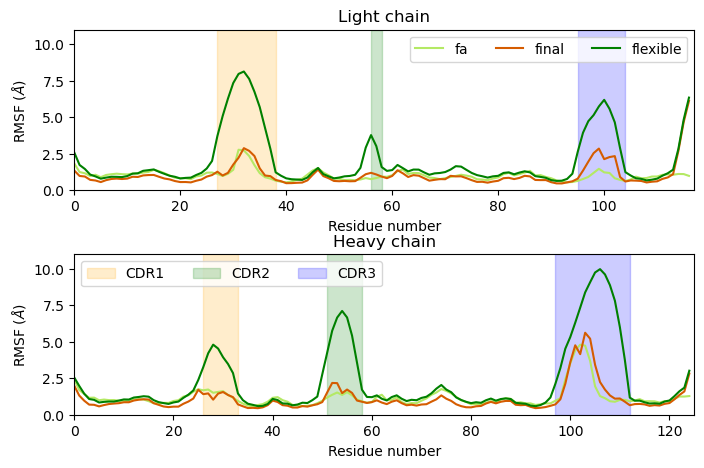

In [98]:
fig,(axs)=plt.subplots(2,1,figsize=(8,5),gridspec_kw={'hspace': 0.4})

axs[0].plot([i for i in range(len(res_light))],rmsf_fa_light[:117],color='#b4e964',label='fa')
axs[0].plot([i for i in range(len(res_light_final))],rmsf_final_light, label='final',color='#d55c00')
axs[0].plot([i for i in range(len(res_light_final))],rmsf_flexible_light, label='flexible',color='green')

axs[0].set_xlabel('Residue number')
axs[0].set_ylabel('RMSF ($\AA$)')
axs[0].axvspan(cv3_cdrs_light_sim[0][0]-start_chain_light,cv3_cdrs_light_sim[0][1]-start_chain_light, zorder=0, alpha=0.2, color='orange')
axs[0].axvspan(cv3_cdrs_light_sim[1][0]-start_chain_light,cv3_cdrs_light_sim[1][1]-start_chain_light, zorder=0, alpha=0.2, color='green')
axs[0].axvspan(cv3_cdrs_light_sim[2][0]-start_chain_light,cv3_cdrs_light_sim[2][1]-start_chain_light, zorder=0, alpha=0.2, color='blue')
axs[0].set_ylim(0,11)
axs[0].set_title('Light chain')
axs[0].set_xlim(0,len(res_light))
axs[0].legend(ncol=3)


axs[1].plot([i for i in range(len(res_heavy))],rmsf_fa_heavy[:len(res_heavy)],color='#b4e964')
axs[1].plot([i for i in range(len(res_heavy_final))],rmsf_final_heavy,color='#d55c00')
axs[1].plot([i for i in range(len(res_heavy_final))],rmsf_flexible_heavy,color='green')

axs[1].set_xlabel('Residue number')
axs[1].set_ylabel('RMSF ($\AA$)')
axs[1].axvspan(cv3_cdrs_heavy_sim[0][0],cv3_cdrs_heavy_sim[0][1], zorder=0, alpha=0.2, color='orange', label='CDR1')
axs[1].axvspan(cv3_cdrs_heavy_sim[1][0],cv3_cdrs_heavy_sim[1][1], zorder=0, alpha=0.2, color='green', label='CDR2')
axs[1].axvspan(cv3_cdrs_heavy_sim[2][0],cv3_cdrs_heavy_sim[2][1], zorder=0, alpha=0.2, color='blue', label='CDR3')
axs[1].set_ylim(0,11)
axs[1].legend(ncol=3)
axs[1].set_title('Heavy chain')

axs[1].set_xlim(0,len(res_heavy))
plt.savefig('../figures/3V6F_comparison_rmsf_cv3_setups.pdf')
#print('RMSE light all chain:',rmse_light_all)
#print('RMSE heavy all chain:',rmse_heavy_all)

['fa', 'sim_final', 'sim_flexible', 'metad']


/var/folders/8w/2dqxrgsd4vj00wv819dcz51w0000gn/T/ipykernel_59434/327330915.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


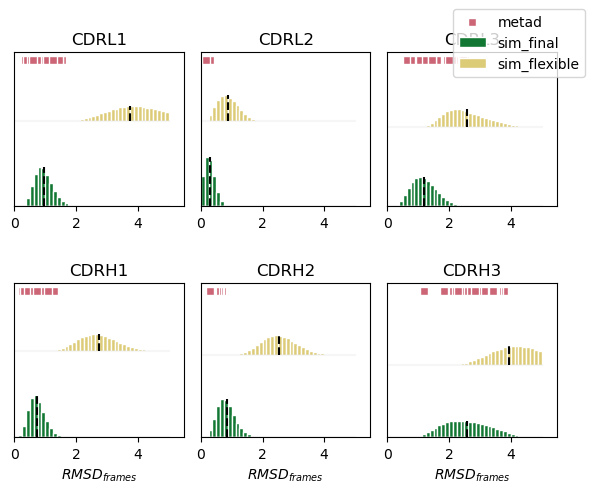

In [99]:
fig, axes = plt.subplots(2, 3, figsize=(7, 5),
                         gridspec_kw={'hspace': 0.5, 'wspace': 0.1})
colors = ['#88CCEE','#117733','#DDCC77','#CC6677','#AB6D52']  # One color per method
methods = ['fa','sim_final', 'sim_flexible','metad'] 
print(methods)
# Ensure axes is 2D
axes = np.atleast_2d(axes)
for row_idx,chain_id in enumerate(['light','heavy']):
    for col_idx, cdr in enumerate([1, 2, 3]):
        ax = axes[row_idx, col_idx]
        bottom_meth=0
        for method_idx, method in enumerate(methods):
            try:
                data = rmsd_all_dist[method][chain_id][(cdr)-1]
                if method == 'metad':
                    y = [bottom_meth] * len(data)
                    ax.scatter(data, y, facecolor=colors[method_idx], edgecolor='white',marker='s', 
                               s=30., label=method if row_idx == 0 else "")
                    
                else:
                    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

                    data_sum = data.sum()
                    data_normalized = data / data_sum
                    
                    ax.bar(bin_centers, data_normalized, width=(bin_edges[1] - bin_edges[0]),color=colors[method_idx], edgecolor='w',
                           label=method if row_idx == 0 else "",bottom=bottom_meth)
                    mean = np.sum(bin_centers * data_normalized)
                    
                    ax.plot([0,5],[bottom_meth,bottom_meth],color='lightgray',alpha=0.2)
                    ax.plot([mean,mean],[bottom_meth,bottom_meth+np.max(data_normalized)],ls='--',color='k')
                    bottom_meth=bottom_meth+np.max(data_normalized)+0.2
                    
            except KeyError:
                pass
    
        ax.set_xlim(0, 5.5)
        ax.set_yticks([])
        if row_idx == len(pdb_list) - 1:
            ax.set_xlabel(r'$ RMSD_{frames}$')
        if row_idx == 0:
            ax.set_title(f"CDRL{cdr}")
        if row_idx == 1:
            ax.set_title(f"CDRH{cdr}")
# Add a legend only once
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.95, 0.98))
plt.tight_layout()

plt.savefig(f'../figures/{system_name}_sims_metad_rmsd_pairwise_cv3_setups.pdf')

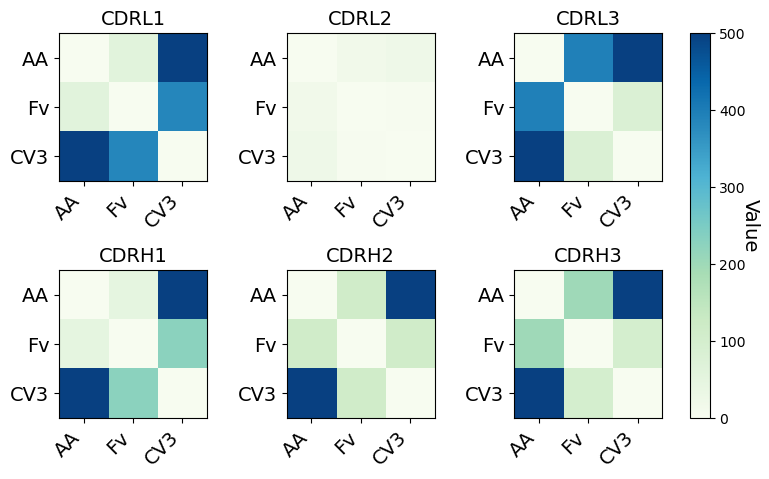

In [100]:
fig, axs = plt.subplots(2, 3, figsize=(9, 5), gridspec_kw={'hspace': 0.6, 'wspace': 0.25})
labels = ['AA', 'Fv', 'CV3']  # your custom tick labels

axs = axs.flatten()

# Keep a reference to one image to attach the shared colorbar
im = None

for idx, cdr in enumerate(hes_matrix_3v6f.keys()):
    im = axs[idx].imshow(hes_matrix_3v6f[cdr], cmap='GnBu', vmin=0, vmax=500)

    axs[idx].set_title(cdr, fontsize=14)

    # Set tick positions and labels
    axs[idx].set_xticks(range(len(labels)))
    axs[idx].set_xticklabels(labels, rotation=45, ha='right', fontsize=14)

    axs[idx].set_yticks(range(len(labels)))
    axs[idx].set_yticklabels(labels, fontsize=14)

# One shared colorbar on the right
cbar = fig.colorbar(im, ax=axs, location='right', fraction=0.046, pad=0.04)
cbar.ax.set_ylabel('Value', rotation=270, labelpad=10, fontsize=14)

plt.savefig('../figures/hes_matrices_3v6f.pdf')